# Get the Rating Matrix

In [3]:
import pickle 

pickle_in = open("../datasets/rating_matrix.pickle","rb")
rating_matrix = pickle.load(pickle_in) 
pickle_in.close() 

In [4]:
type(rating_matrix)

dict

In [2]:
# !pip install apyori

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=5974 sha256=31630df4a3835c608202f402a20e4fb9ce2a277f83f761d71b56ebd63c39e15d
  Stored in directory: c:\users\melih.kacaman\appdata\local\pip\cache\wheels\32\2a\54\10c595515f385f3726642b10c60bf788029e8f3a1323e3913a
Successfully built apyori



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [106]:
# !pip install mlxtend  



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



     ---------------------------------------- 1.3/1.3 MB 3.3 MB/s eta 0:00:00


In [5]:
len(rating_matrix)

771062

In [6]:
import pandas as pd 

data = pd.Series(rating_matrix).reset_index() 
data.columns = ["option_x", "option_y", "rating"] 

data.head() 

,option_x,option_y,rating
0,745321,666652,1
1,745321,751782,1
2,745321,751839,10
3,666652,751782,1
4,666652,751839,1


In [7]:
data.describe()

,option_x,option_y,rating
count,771062.000000,771062.000000,771062.000000
mean,735325.372226,735395.857417,2.418680
std,42364.768430,42085.392109,9.794105
min,16329.000000,10494.000000,1.000000
25%,714744.000000,714645.000000,1.000000
50%,751526.000000,751358.000000,1.000000
75%,760344.000000,760209.000000,2.000000
max,823758.000000,823758.000000,2254.000000


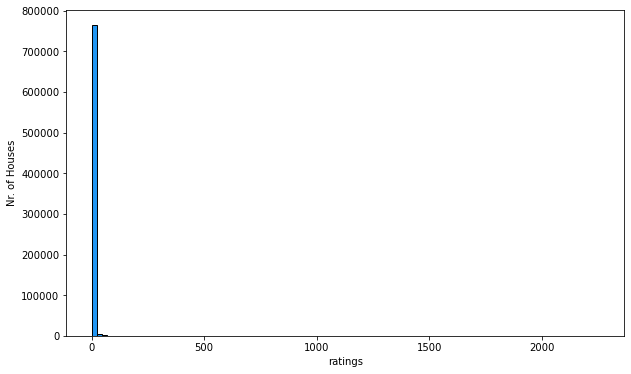

In [9]:
# If the distribution of the quantity is normal, then it should be standardized, otherwise, the data should be normalized.
import matplotlib.pyplot as plt 

plt.figure(figsize=(10,6))
plt.hist(data['rating'], bins=100, ec='black', color='#2196f3')
plt.xlabel('ratings')
plt.ylabel('Nr. of Houses')
plt.show()

c:\Users\melih.kacaman\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

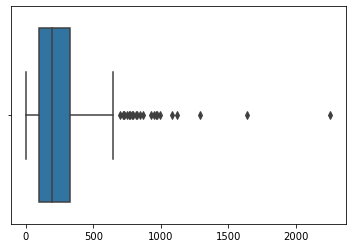

In [10]:
import seaborn as sns
sns.boxplot(data['rating'].unique())

In [12]:
import numpy as np 
Q1 = np.percentile(data['rating'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(data['rating'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1

IQR 

1.0

In [101]:
data_greater_1 = data[data.rating > 1] 

data_greater_1.head() 

,option_x,option_y,rating
2,745321,751839,10
5,751782,751839,151
6,751873,760125,107
7,772494,754574,12
9,772494,749358,11


# Model 1 using Keras 

In [16]:
from sklearn.utils import shuffle 
from keras.models import Model 
from keras.layers import Input, Embedding, Dense, Flatten, Concatenate, Activation

N = len(data.option_x.unique()) 
M = len(data.option_y.unique()) 

data_shuffled = shuffle(data) 

# initialize the latent vector dimension 
K = 10 
mu = data.rating.mean() 
epochs = 25 

u = Input(shape=(1,))
m = Input(shape=(1,))

u_embedding = Embedding(N, K)(u) # u -> u_embdedding
m_embedding = Embedding(M, K)(m) # m -> m_embedding 

u_embedding = Flatten()(u_embedding) # (N, K)
m_embedding = Flatten()(m_embedding) # (N, K)

x = Concatenate()([u_embedding, m_embedding]) # (N, 2K)
x = Dense(400)(x)
x = Activation('relu')(x)
x = Dense(1)(x)

model = Model(inputs=[u, m], outputs=x)  # Function 1 fulfilled

In [ ]:
from keras.optimizers import SGD

model.compile(
  loss='mse',
  optimizer=SGD(lr=0.08, momentum=0.9),
  metrics=['mse'],
)

In [ ]:
history_model = model.fit(
    x= [data_shuffled.option_x.values, data_shuffled.option_y.values], 
    y= data_shuffled.rating.values, 
    batch_size=128, 
    epochs=25
)

# Model 2: Apriori 

In [14]:
from apyori import apriori 

In [102]:
transactions = [] 

for index,row in data_greater_1.iterrows(): 
    transaction = [str(row.option_x), str(row.option_y)]

    for i in range(row.rating):
        transactions.append(transaction) 

In [110]:
associations = apriori(
    transactions,
    min_length = 2,
    min_support = 0.001,
    min_confidence = 0.001,
    min_lift = 0.001
)

associations = list(associations)
len(associations)

533

In [111]:
associations

[RelationRecord(items=frozenset({'525099'}), support=0.00274991827296754, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'525099'}), confidence=0.00274991827296754, lift=1.0)]),
 RelationRecord(items=frozenset({'525100'}), support=0.013250626324557683, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'525100'}), confidence=0.013250626324557683, lift=1.0)]),
 RelationRecord(items=frozenset({'614682'}), support=0.0014737048416066524, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'614682'}), confidence=0.0014737048416066524, lift=1.0)]),
 RelationRecord(items=frozenset({'614684'}), support=0.002046729160728833, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'614684'}), confidence=0.002046729160728833, lift=1.0)]),
 RelationRecord(items=frozenset({'614690'}), support=0.0010675009182602503, ordered_statistics=[OrderedStatistic(items_base=frozenset(), ite